<a href="https://colab.research.google.com/github/4juneko/Aiffel_work/blob/master/18_NL_movieGrade_Korean_06072023.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Rubric
|평가문항|	상세기준|내 평가|
|--|--|--|
|1. 다양한 방법으로 Text Classification 태스크를 성공적으로 구현하였다.	|3가지 이상의 모델이 성공적으로 시도됨|O|
|2. gensim을 활용하여 자체학습된 혹은 사전학습된 임베딩 레이어를 분석하였다.	|gensim의 유사단어 찾기를 활용하여 자체학습한 임베딩과 사전학습 임베딩을 비교 분석함|O||
|3. 한국어 Word2Vec을 활용하여 가시적인 성능향상을 달성했다.|	네이버 영화리뷰 데이터 감성분석 정확도를 85% 이상 달성함|O|

# 1 Import Library

In [ ]:
import pandas
import konlpy
import gensim

print(pandas.__version__)
print(konlpy.__version__)
print(gensim.__version__)

1.3.3
0.5.2
4.1.2


# 2 Prepare Data

In [ ]:
import pandas as pd

# 데이터를 읽어봅시다. 
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

train_data.head()


,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


# 3 Preprocess Data
- 데이터의 중복 제거
- NaN 결측치 제거
- 한국어 토크나이저로 토큰화
- 불용어(Stopwords) 제거
- 사전word_to_index 구성
- 텍스트 스트링을 사전 인덱스 스트링으로 변환
- X_train, y_train, X_test, y_test, word_to_index 리턴  
</br>

- 데이터셋 내 문장 길이 분포
- 적절한 최대 문장 길이 지정
- keras.preprocessing.sequence.pad_sequences 을 활용한 패딩 추가


In [ ]:
from konlpy.tag import Mecab
import numpy as np
from collections import Counter

tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 
    
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)
    
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['', '', '', ''] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
        
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index[''] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
        
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
    
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data) 
len(X_train), len(X_test)

(146182, 49157)

In [ ]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [ ]:
# print(word_to_index)

In [ ]:
#실제 인코딩 인덱스는 제공된 word_to_index에서 index 기준으로 3씩 뒤로 밀려 있습니다.  
# word_to_index = {k:(v+3) for k,v in word_to_index.items()}

# 처음 몇 개 인덱스는 사전에 정의되어 있습니다.
word_to_index["<PAD>"] = 0
word_to_index["<BOS>"] = 1
word_to_index["<UNK>"] = 2  # unknown
word_to_index["<UNUSED>"] = 3

index_to_word = {index:word for word, index in word_to_index.items()}

print(index_to_word[1])     # '<BOS>' 가 출력됩니다. 
print(word_to_index['영화'])  # 4 이 출력됩니다. 
print(index_to_word[5])     # 'the' 가 출력됩니다.

<BOS>
5
영화


In [ ]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

## Padding 

In [ ]:
# 데이터셋 내 문장 길이 분포
total_data_text = list(X_train) + list(X_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

문장길이 평균 :  15.96940191154864
문장길이 최대 :  116
문장길이 표준편차 :  12.843571191092


In [ ]:
# 적절한 최대 문장 길이 지정
# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)*100))

pad_sequences maxlen :  41
전체 문장의 93.42988343341575%가 maxlen 설정값 이내에 포함됩니다. 


In [ ]:
import tensorflow as tf
import os

# keras.preprocessing.sequence.pad_sequences를 활용한 pad 추가
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='pre', # 혹은 'post'
                                                        maxlen=maxlen)

X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='pre', # 혹은 'post'
                                                       maxlen=maxlen)

print(X_train.shape)

(146182, 41)


In [ ]:
print(X_train[0])

[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0  32  74 919   4   4
  39 228  20  33 748]


In [ ]:
print(X_test[0])

[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0 832 130]


# 4 Split Data

In [ ]:
# validation set 50000건 분리
X_val = X_train[:50000]   
y_val = y_train[:50000]

# validation set을 제외한 나머지 96000건
partial_X_train = X_train[50000:]  
partial_y_train = y_train[50000:]

print(partial_X_train.shape)
print(partial_y_train.shape)
print(X_val.shape)
print(y_val.shape)

(96182, 41)
(96182,)
(50000, 41)
(50000,)


# 5 Get Model & Train

## 5-1 Model #1 - LSTM

In [ ]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 16  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

# model1 설계 - 딥러닝 모델 코드를 직접 작성해 주세요.
model1 = tf.keras.Sequential()
# [[YOUR CODE]]
model1.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model1.add(tf.keras.layers.LSTM(128))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경 가능)
model1.add(tf.keras.layers.Dense(8, activation='relu'))
model1.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model1.summary()

Model: "sequential_39"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_39 (Embedding)     (None, None, 16)          160000    
_________________________________________________________________
lstm_21 (LSTM)               (None, 128)               74240     
_________________________________________________________________
dense_79 (Dense)             (None, 8)                 1032      
_________________________________________________________________
dense_80 (Dense)             (None, 1)                 9         
Total params: 235,281
Trainable params: 235,281
Non-trainable params: 0
_________________________________________________________________


In [ ]:
adam = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

model1.compile(optimizer= adam,
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=15  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 20은 과대적합이어서 5로 바꿈

history1 = model1.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

# https://wikidocs.net/36033

Epoch 1/15
188/188 [==============================] - 4s 13ms/step - loss: 0.6702 - accuracy: 0.6163 - val_loss: 0.6131 - val_accuracy: 0.6515
Epoch 2/15
188/188 [==============================] - 2s 10ms/step - loss: 0.5386 - accuracy: 0.7514 - val_loss: 0.4957 - val_accuracy: 0.7331
Epoch 3/15
188/188 [==============================] - 2s 10ms/step - loss: 0.4363 - accuracy: 0.8083 - val_loss: 0.4173 - val_accuracy: 0.8214
Epoch 4/15
188/188 [==============================] - 2s 10ms/step - loss: 0.3998 - accuracy: 0.8259 - val_loss: 0.4019 - val_accuracy: 0.8228
Epoch 5/15
188/188 [==============================] - 2s 10ms/step - loss: 0.3717 - accuracy: 0.8406 - val_loss: 0.3996 - val_accuracy: 0.8190
Epoch 6/15
188/188 [==============================] - 2s 10ms/step - loss: 0.3567 - accuracy: 0.8471 - val_loss: 0.3799 - val_accuracy: 0.8307
Epoch 7/15
188/188 [==============================] - 2s 10ms/step - loss: 0.3436 - accuracy: 0.8532 - val_loss: 0.3670 - val_accuracy: 0.8400

In [ ]:
results1 = model1.evaluate(X_test,  y_test, verbose=2)

print(results1)

1537/1537 - 4s - loss: 0.3740 - accuracy: 0.8392
[0.3740371763706207, 0.8391886949539185]


In [ ]:
history_dict1 = history1.history
print(history_dict1.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


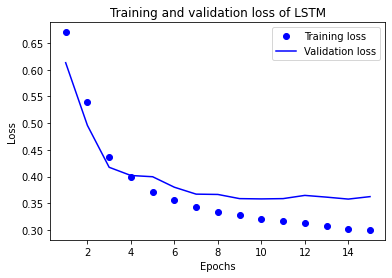

In [ ]:
import matplotlib.pyplot as plt

acc = history_dict1['accuracy']
val_acc = history_dict1['val_accuracy']
loss = history_dict1['loss']
val_loss = history_dict1['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss of LSTM')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

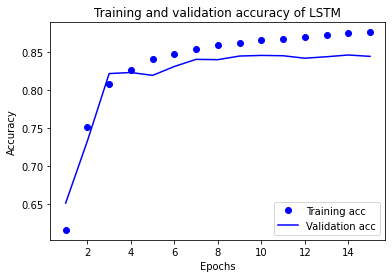

In [ ]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy of LSTM')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

- 과적합이 있어 learning rate를 0.00001로 정하여 학습하였더니 과적합이 없어졌음.
- 학습이 진행됨에 따라 accracy 값이 수렴되어 모델에 레이어를 추가하여 학습하여도 나아지는 것이 없었음.
- model의 LSTM state vector의 차원수를 8~256으로 여러 모델을 학습해보니 값에 따라 accuracy에 영향이 조금 있음을 알았음.
- accuracy는 0.84

## 5-2 Model #2 - Conv1D

In [ ]:
vocab_size = 10000  # 어휘 사전의 크기입니다(10개의 단어)
word_vector_dim = 16   # 단어 하나를 표현하는 임베딩 벡터의 차원 수입니다. 

model2 = tf.keras.Sequential()
model2.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model2.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model2.add(tf.keras.layers.MaxPooling1D(5))
model2.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model2.add(tf.keras.layers.GlobalMaxPooling1D())
model2.add(tf.keras.layers.Dense(8, activation='relu'))
model2.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model2.summary()

Model: "sequential_40"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_40 (Embedding)     (None, None, 16)          160000    
_________________________________________________________________
conv1d_26 (Conv1D)           (None, None, 16)          1808      
_________________________________________________________________
max_pooling1d_14 (MaxPooling (None, None, 16)          0         
_________________________________________________________________
conv1d_27 (Conv1D)           (None, None, 16)          1808      
_________________________________________________________________
global_max_pooling1d_18 (Glo (None, 16)                0         
_________________________________________________________________
dense_81 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_82 (Dense)             (None, 1)               

In [ ]:
adam = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

model2.compile(optimizer=adam,
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=15  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history2 = model2.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/15
188/188 [==============================] - 2s 7ms/step - loss: 0.6921 - accuracy: 0.5389 - val_loss: 0.6901 - val_accuracy: 0.5821
Epoch 2/15
188/188 [==============================] - 1s 6ms/step - loss: 0.6794 - accuracy: 0.6565 - val_loss: 0.6574 - val_accuracy: 0.7340
Epoch 3/15
188/188 [==============================] - 1s 5ms/step - loss: 0.5969 - accuracy: 0.7660 - val_loss: 0.5260 - val_accuracy: 0.7957
Epoch 4/15
188/188 [==============================] - 1s 5ms/step - loss: 0.4669 - accuracy: 0.8110 - val_loss: 0.4283 - val_accuracy: 0.8195
Epoch 5/15
188/188 [==============================] - 1s 6ms/step - loss: 0.3987 - accuracy: 0.8316 - val_loss: 0.3902 - val_accuracy: 0.8317
Epoch 6/15
188/188 [==============================] - 1s 5ms/step - loss: 0.3668 - accuracy: 0.8444 - val_loss: 0.3731 - val_accuracy: 0.8376
Epoch 7/15
188/188 [==============================] - 1s 5ms/step - loss: 0.3475 - accuracy: 0.8524 - val_loss: 0.3643 - val_accuracy: 0.8419
Epoch 

In [ ]:
results2 = model2.evaluate(X_test,  y_test, verbose=2)

print(results2)

1537/1537 - 2s - loss: 0.3681 - accuracy: 0.8416
[0.36807698011398315, 0.8416298627853394]


In [ ]:
history_dict2 = history2.history
print(history_dict2.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


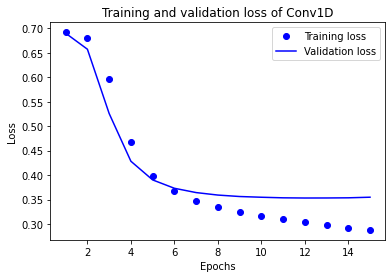

In [ ]:
import matplotlib.pyplot as plt

acc = history_dict2['accuracy']
val_acc = history_dict2['val_accuracy']
loss = history_dict2['loss']
val_loss = history_dict2['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss of Conv1D')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

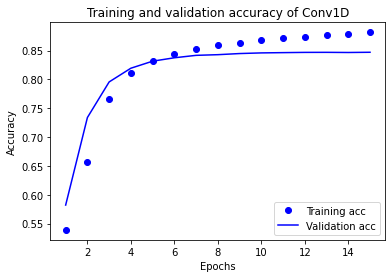

In [ ]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy of Conv1D')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

- learning rate를 변경하면서 학습을 하여 과적합을 방지하였으나 accuracy가 0.84로 0.85를 못미치고 수렴함. 

## 5-3 Model #3 - GlobalMaxPooling

In [ ]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 16  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

# model3 설계 - 딥러닝 모델 코드를 직접 작성해 주세요.
model3 = tf.keras.Sequential()
model3.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model3.add(tf.keras.layers.GlobalMaxPooling1D())
model3.add(tf.keras.layers.Dense(8, activation='relu'))
model3.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model3.summary()

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_20 (Embedding)     (None, None, 16)          160000    
_________________________________________________________________
global_max_pooling1d_11 (Glo (None, 16)                0         
_________________________________________________________________
dense_41 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_42 (Dense)             (None, 1)                 9         
Total params: 160,145
Trainable params: 160,145
Non-trainable params: 0
_________________________________________________________________


In [ ]:
adam = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

model3.compile(optimizer=adam,
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=40  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history3 = model3.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/40
188/188 [==============================] - 1s 5ms/step - loss: 0.6917 - accuracy: 0.5239 - val_loss: 0.6895 - val_accuracy: 0.5957
Epoch 2/40
188/188 [==============================] - 1s 4ms/step - loss: 0.6865 - accuracy: 0.6904 - val_loss: 0.6832 - val_accuracy: 0.7352
Epoch 3/40
188/188 [==============================] - 1s 4ms/step - loss: 0.6783 - accuracy: 0.7515 - val_loss: 0.6733 - val_accuracy: 0.7510
Epoch 4/40
188/188 [==============================] - 1s 4ms/step - loss: 0.6653 - accuracy: 0.7697 - val_loss: 0.6572 - val_accuracy: 0.7751
Epoch 5/40
188/188 [==============================] - 1s 4ms/step - loss: 0.6466 - accuracy: 0.7879 - val_loss: 0.6374 - val_accuracy: 0.7843
Epoch 6/40
188/188 [==============================] - 1s 4ms/step - loss: 0.6250 - accuracy: 0.7964 - val_loss: 0.6151 - val_accuracy: 0.7907
Epoch 7/40
188/188 [==============================] - 1s 4ms/step - loss: 0.6010 - accuracy: 0.8033 - val_loss: 0.5908 - val_accuracy: 0.7978
Epoch 

In [ ]:
results3 = model3.evaluate(X_test,  y_test, verbose=2)

print(results3)

1537/1537 - 2s - loss: 0.3659 - accuracy: 0.8396
[0.3659473657608032, 0.8396362662315369]


In [ ]:
history_dict3 = history3.history
print(history_dict1.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


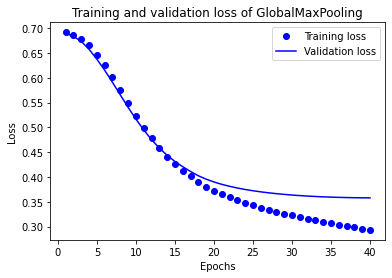

In [ ]:
import matplotlib.pyplot as plt

acc = history_dict3['accuracy']
val_acc = history_dict3['val_accuracy']
loss = history_dict3['loss']
val_loss = history_dict3['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss' )
plt.title('Training and validation loss of GlobalMaxPooling')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

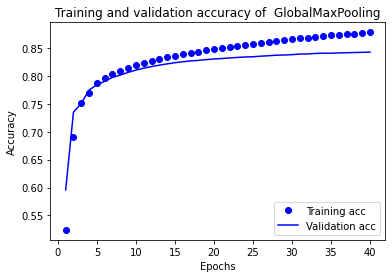

In [ ]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy of  GlobalMaxPooling')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

- learning rate를 변경하면서 학습을 하여서 과적합을 방지하였으나 accuracy가 0.84으로 0.85를 넘기지 못하고 수렴함. 
- 다른 모델과 다르게 학습이 진행됨에 따라 아주 조금씩 accuracy 값이 증가하였으나 너무 미미함.

# 6 Apply word2vec

## 6-1 Model #1 - LSTM

In [ ]:
embedding_layer = model1.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(10000, 16)


In [ ]:
# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model1.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [ ]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['사랑']
vector

array([-0.01853147, -0.04775202, -0.0170002 , -0.06178223, -0.05722797,
       -0.0274931 ,  0.05500198,  0.01069494,  0.02993739, -0.03604026,
        0.06194439,  0.01824616,  0.03728649, -0.0581596 , -0.08203577,
        0.00696354], dtype=float32)

In [ ]:
word_vectors.similar_by_word("사랑")

[('+_+', 0.8416579961776733),
 ('♥', 0.834623396396637),
 ('~~~^^', 0.8291171193122864),
 ('ㅠㅠㅠㅠ', 0.8159509897232056),
 ('레전드', 0.8112607002258301),
 ('and', 0.8074216246604919),
 ('풀어낸', 0.7994033098220825),
 ('꿀', 0.7982859015464783),
 ('조지클루니', 0.7889705896377563),
 ('이럼', 0.787347137928009)]

## 6-2 Model #2 - Conv1D

In [ ]:
embedding_layer = model2.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(10000, 16)


In [ ]:
# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model2.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [ ]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['사랑']
vector

array([ 0.03860593,  0.10255454, -0.06752539,  0.00237153, -0.10219191,
        0.02654306,  0.02306216,  0.09206163,  0.00111349,  0.01726603,
        0.02664051, -0.07563262,  0.01546772,  0.05534345, -0.04188529,
       -0.0454713 ], dtype=float32)

In [ ]:
word_vectors.similar_by_word("사랑")

[('한층', 0.9175457954406738),
 ('토마스', 0.9146274924278259),
 ('가슴', 0.8799096345901489),
 ('바탕', 0.8476906418800354),
 ('주도', 0.8361486196517944),
 ('괜찮', 0.8321218490600586),
 ('찔끔', 0.8271863460540771),
 ('할게요', 0.8264355659484863),
 ('찰리채플린', 0.8191215395927429),
 ('삽입곡', 0.8184922337532043)]

## 6-3 Model #3 - GlobalMaxPooling

In [ ]:
embedding_layer = model3.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(10000, 16)


In [ ]:
# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model3.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [ ]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['사랑']
vector

array([-0.10279344, -0.08083493, -0.1001664 , -0.06199542,  0.16362794,
        0.17985938, -0.10149472, -0.08822759, -0.06724613, -0.05730183,
       -0.07233708,  0.23360653, -0.07610017,  0.04680521,  0.02978873,
       -0.02427046], dtype=float32)

In [ ]:
word_vectors.similar_by_word("사랑")

[('김동완', 0.9434136748313904),
 ('드라마틱', 0.928017258644104),
 ('짐', 0.9236149191856384),
 ('자격', 0.9213548302650452),
 ('하나하나', 0.9152548909187317),
 ('~~!!!', 0.8976755142211914),
 ('살아오', 0.8948375582695007),
 ('중독', 0.8925775289535522),
 ('ost', 0.8896813988685608),
 ('재미나', 0.888985812664032)]

# 7 Use Word2Vec Model

In [ ]:
# load word2vec
from gensim.models import KeyedVectors
from gensim.models.keyedvectors import Word2VecKeyedVectors

word2vec_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vec_ko.model'
word_vectors = Word2VecKeyedVectors.load(word2vec_path)


In [ ]:
vector = word_vectors.wv['사랑']
vector.shape

(100,)

In [ ]:
word_vectors.wv.most_similar("사랑")

[('이별', 0.7626414895057678),
 ('행복', 0.7550068497657776),
 ('슬픔', 0.7381505966186523),
 ('유혹', 0.7238055467605591),
 ('그리움', 0.7167419195175171),
 ('추억', 0.7143999338150024),
 ('꿈', 0.7089294195175171),
 ('애정', 0.7066588997840881),
 ('포옹', 0.7034594416618347),
 ('마음', 0.6972615718841553)]

In [ ]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 100  # 워드 벡터의 차원수
embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드 벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in word_vectors.wv:
        embedding_matrix[i] = word_vectors.wv[index_to_word[i]]

In [ ]:
from tensorflow.keras.initializers import Constant

vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 100  # 워드 벡터의 차원 수 

# 모델 구성
model4 = tf.keras.Sequential()
model4.add(tf.keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))
model4.add(tf.keras.layers.LSTM(128))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경 가능)
model4.add(tf.keras.layers.Dense(32, activation='relu'))
model4.add(tf.keras.layers.Dense(8, activation='relu'))
model4.add(tf.keras.layers.Dense(1, activation='sigmoid')) 

model4.summary()




# model2 = tf.keras.Sequential()
# model2.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
# model2.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
# model2.add(tf.keras.layers.MaxPooling1D(5))
# model2.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
# model2.add(tf.keras.layers.GlobalMaxPooling1D())
# model2.add(tf.keras.layers.Dense(8, activation='relu'))
# model2.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

# model2.summary()

Model: "sequential_50"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_50 (Embedding)     (None, 41, 100)           1000000   
_________________________________________________________________
lstm_31 (LSTM)               (None, 128)               117248    
_________________________________________________________________
dense_104 (Dense)            (None, 32)                4128      
_________________________________________________________________
dense_105 (Dense)            (None, 8)                 264       
_________________________________________________________________
dense_106 (Dense)            (None, 1)                 9         
Total params: 1,121,649
Trainable params: 1,121,649
Non-trainable params: 0
_________________________________________________________________


Epoch 1/15
188/188 [==============================] - 5s 14ms/step - loss: 0.5707 - accuracy: 0.7013 - val_loss: 0.4981 - val_accuracy: 0.7597
Epoch 2/15
188/188 [==============================] - 2s 12ms/step - loss: 0.4724 - accuracy: 0.7757 - val_loss: 0.4494 - val_accuracy: 0.7929
Epoch 3/15
188/188 [==============================] - 2s 12ms/step - loss: 0.4305 - accuracy: 0.8023 - val_loss: 0.4190 - val_accuracy: 0.8096
Epoch 4/15
188/188 [==============================] - 2s 12ms/step - loss: 0.4006 - accuracy: 0.8193 - val_loss: 0.4156 - val_accuracy: 0.8106
Epoch 5/15
188/188 [==============================] - 2s 12ms/step - loss: 0.3755 - accuracy: 0.8324 - val_loss: 0.3990 - val_accuracy: 0.8207
Epoch 6/15
188/188 [==============================] - 2s 12ms/step - loss: 0.3542 - accuracy: 0.8448 - val_loss: 0.3775 - val_accuracy: 0.8322
Epoch 7/15
188/188 [==============================] - 2s 12ms/step - loss: 0.3380 - accuracy: 0.8525 - val_loss: 0.3727 - val_accuracy: 0.8354

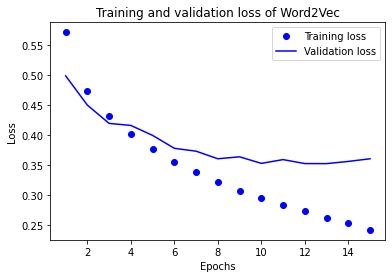

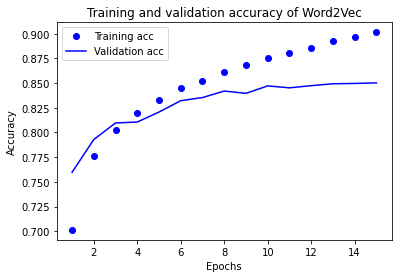

In [ ]:
adam = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

model4.compile(optimizer=adam,
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=15  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model4.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

results4 = model4.evaluate(X_test,  y_test, verbose=2)

print(results4)

history_dict4 = history.history
print(history_dict4.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

import matplotlib.pyplot as plt

acc = history_dict4['accuracy']
val_acc = history_dict4['val_accuracy']
loss = history_dict4['loss']
val_loss = history_dict4['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss of Word2Vec')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy of Word2Vec')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

- 모델에 dense layer를 하나 더 추가하여 accuracy 0.85를 얻을 수 있었다.

# Review
- gesim을 활용한 유사 단어 찾기(사랑) 및 학습 결과

||자체 학습한 |embedding||사전 학습한 embedding|
|--|--|--|--|--|
||LSTM|Conv1D|GlobalMaxPooling|word2vec|
|유사 단어|+_+,♥,~~~^^,ㅠㅠㅠㅠ,레전드,and,</br>풀어낸,꿀,조지클루니,이럼|한층,토마스,가슴,바탕,주도,</br>괜찮,찔끔,할게요,찰리채플린,삽입곡|김동완,드라마틱,짐,자격,하나하나,</br>~~!!!,살아오,중독,ost,재미나|이별,행복,슬픔,유혹,그리움,</br>추억,꿈,애정,포옹,마음|
|유사도|0.78~0.84|0.82~0.92|0.89~0.94|0.70~0.76|
|accuracy|0.84|0.84|0.84|0.85|  

- 자체 학습한 embedding은 각 모델의 첫번째 레이어의 정보를 가지고 온 것인데 모든 조건이 같고 첫번째 레이어라서 같은 embedding일 것이라고 예상했지만 각각 다른 값을 보여주었음.
- 자체 학습한 것의 유사도가 사전학습한 거보다 크지만 관련없는 단어들의 모임이었음.
- 자체 학습한 embedding의 유사 단어 결과가 좋지 않았던 것은 데이터세트가 온전한 글의 모임이 아니라 영화를 평가하는 짧은 댓글이었기 때문일 거라 예상됨. 
- 학습율을 조정하여 과적합을 방지할 수 있었음.
- accuracy를 높이기 위해 LSTM의 모델을 수정하였음. 특히, word2vec를 적용한 모델은 dense layer를 추가하여 0.85 기준을 맞출 수 있었음.
